CASE 1. Fully connected Neural Network (in this case a 3 layer version)
For 840 paramter version replace model class with

class CompactNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(84, 10)
        #self.fc2 = nn.Linear(10, 15)
        #self.fc3 = nn.Linear(15, 10)

    def forward(self, x):
        #x = F.tanh(self.fc1(x))
        #x = F.tanh(self.fc2(x))
        return (self.fc1(x))

model = CompactNN()



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import Subset, DataLoader, TensorDataset
import time

start_time = time.time()
# Steg 1: Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
traindata=10000
train_subset = Subset(train_set, range(traindata))
test_subset = Subset(test_set, range(1000))

train_loader100 = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader100 = DataLoader(test_subset, batch_size=32, shuffle=False)

def cartesian_to_polar(img):
    center = (img.shape[1] // 2, img.shape[0] // 2)
    maxRadius = min(center[0], center[1])
    polar_img = cartesian_to_polar_manual(img)
    return polar_img

def polar_to_cartesian(polar_img):
    center = (polar_img.shape[1] // 2, polar_img.shape[0] // 2)
    maxRadius = min(center[0], center[1])
    cartesian_img = polar_to_cartesian_manual(polar_img)
    return cartesian_img

def cartesian_to_polar_manual(cartesian_img, output_shape=(28, 28), center=None, max_radius=None):
    H, W = output_shape
    if center is None:
        center = (cartesian_img.shape[1] // 2, cartesian_img.shape[0] // 2)
    if max_radius is None:
        max_radius = min(center[0], center[1])

    polar_img = np.zeros((H, W), dtype=np.float32)
    theta_vals = np.linspace(-np.pi, np.pi, H)
    radius_vals = np.linspace(0, max_radius, W)

    for i, theta in enumerate(theta_vals):
        for j, r in enumerate(radius_vals):
            x = center[0] + r * np.cos(theta)
            y = center[1] + r * np.sin(theta)
            x0 = int(np.floor(x))
            x1 = min(x0 + 1, cartesian_img.shape[1] - 1)
            y0 = int(np.floor(y))
            y1 = min(y0 + 1, cartesian_img.shape[0] - 1)
            dx = x - x0
            dy = y - y0
            if 0 <= x0 < cartesian_img.shape[1] and 0 <= y0 < cartesian_img.shape[0]:
                top = (1 - dx) * cartesian_img[y0, x0] + dx * cartesian_img[y0, x1]
                bottom = (1 - dx) * cartesian_img[y1, x0] + dx * cartesian_img[y1, x1]
                polar_img[i, j] = (1 - dy) * top + dy * bottom
    polar_img = np.flipud(polar_img)
    return np.flipud(polar_img)

def polar_to_cartesian_manual(polar_img, output_size=28, center=None, max_radius=None):
    H, W = polar_img.shape
    if center is None:
        center = (output_size // 2, output_size // 2)
    if max_radius is None:
        max_radius = output_size // 2

    cartesian = np.zeros((output_size, output_size), dtype=np.float32)
    y_indices, x_indices = np.indices((output_size, output_size))
    dx = x_indices - center[0]
    dy = y_indices - center[1]
    r = np.sqrt(dx**2 + dy**2)
    theta = np.arctan2(dy, dx)
    r_norm = r / max_radius
    theta_norm = (theta + np.pi) / (2 * np.pi)
    r_idx = r_norm * (W - 1)
    theta_idx = theta_norm * (H - 1)
    r0 = np.clip(np.floor(r_idx).astype(int), 0, W - 2)
    r1 = r0 + 1
    t0 = np.clip(np.floor(theta_idx).astype(int), 0, H - 2)
    t1 = t0 + 1
    wr = r_idx - r0
    wt = theta_idx - t0
    val = (
        (1 - wr) * (1 - wt) * polar_img[t0, r0] +
        wr * (1 - wt) * polar_img[t0, r1] +
        (1 - wr) * wt * polar_img[t1, r0] +
        wr * wt * polar_img[t1, r1]
    )
    cartesian[r <= max_radius] = val[r <= max_radius]
    return cartesian

class CompactNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(84, 12)
        self.fc2 = nn.Linear(12, 11)
        self.fc3 = nn.Linear(11, 10)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return (self.fc3(x))

model = CompactNN()

# ------------------------
# Skapa 100 polära bilder från train_subset
# ------------------------
polar_images = []
class_polar_reference = {}
seen_classes = set()

for img, label in train_subset:
    img_np = img.squeeze().numpy()
    polar_img = cartesian_to_polar(img_np)
    polar_images.append(polar_img)
    class_label = label.item() if hasattr(label, 'item') else int(label)
    if class_label not in seen_classes:
        class_polar_reference[class_label] = polar_img
        seen_classes.add(class_label)
    if len(seen_classes) == 10:
        break

# ------------------------
# Skapa PCA-bas per klass från referensbilder
# ------------------------
reference_pca_per_class = {}
for cls, polar_img in class_polar_reference.items():
    pca_list = []
    for i in range(polar_img.shape[1]):  # per vinkelsegment (kolumn)
        col = polar_img[:, i].reshape(-1, 1)
        if np.any(col):
            pca = PCA(n_components=min(3, col.shape[0], col.shape[1]))
            try:
                pca.fit(col)
                pca_list.append(pca)
            except Exception:
                pca_list.append(None)
        else:
            pca_list.append(None)
    reference_pca_per_class[cls] = pca_list


# ------------------------
# Extrahera PCA-komponenter för ny bild med klassens referens-PCA
# ------------------------
# ------------------------
def extract_pca_components(image_tensor, label, reference_pca, n_components=3):
    img_np = image_tensor.squeeze().numpy()
    polar_img = cartesian_to_polar(img_np)
    components = []
    pca_list = reference_pca[label.item()]
    for i in range(polar_img.shape[1]):  # per vinkelsegment (kolumn)
        if i >= len(pca_list):
            break
        pca = pca_list[i]
        col = polar_img[:, i].reshape(-1, 1)
        if pca is not None:
            try:
                c = pca.transform(col).flatten()[:n_components]
            except Exception:
                c = [0.0] * n_components
        else:
            c = [0.0] * n_components
        components.extend(c)
    return np.array(components[:84])

polar_data = []
polar_labels = []

for images, labels in train_loader100:
    for img, label in zip(images, labels):
        pca_vector = extract_pca_components(img, label, reference_pca_per_class)
        polar_data.append(pca_vector)
        polar_labels.append(label.item())

polar_data = torch.tensor(polar_data, dtype=torch.float32)
polar_labels = torch.tensor(polar_labels, dtype=torch.long)

polar_dataset = TensorDataset(polar_data, polar_labels)

polarloader = DataLoader(polar_dataset, batch_size=64, shuffle=True)

polar_data_test = []
polar_labels_test = []

for images, labels in test_loader100:
    for img, label in zip(images, labels):
        pca_vector = extract_pca_components(img, label, reference_pca_per_class)
        polar_data_test.append(pca_vector)
        polar_labels_test.append(label.item())

polar_data_test = torch.tensor(polar_data_test, dtype=torch.float32)
polar_labels_test = torch.tensor(polar_labels_test, dtype=torch.long)

polar_dataset = TensorDataset(polar_data_test, polar_labels_test)

polarloader_test = DataLoader(polar_dataset, batch_size=32, shuffle=True)


def train_model_new(model, polarloader, optimizer, criterion):
    model.train()
    for pca_inputs, labels in polarloader:
        pca_inputs = torch.from_numpy(np.array(pca_inputs)).float()
        outputs = model(pca_inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def evaluate_model_new(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(20):
    train_model_new(model, polarloader, optimizer, criterion)
    acc = evaluate_model_new(model, polarloader_test)
    print(f"Epoch {epoch+1}: Accuracy = {acc:.2f}%")

cpu_time = time.time() - start_time
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_parameters(model):,}, {traindata:,} training data: {cpu_time:.4f} seconds")

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decompo

Epoch 1: Accuracy = 85.70%
Epoch 2: Accuracy = 94.00%
Epoch 3: Accuracy = 96.60%
Epoch 4: Accuracy = 97.60%
Epoch 5: Accuracy = 96.20%
Epoch 6: Accuracy = 97.80%
Epoch 7: Accuracy = 98.30%
Epoch 8: Accuracy = 97.90%
Epoch 9: Accuracy = 98.00%
Epoch 10: Accuracy = 98.30%
Epoch 11: Accuracy = 98.70%
Epoch 12: Accuracy = 97.80%
Epoch 13: Accuracy = 99.20%
Epoch 14: Accuracy = 98.90%
Epoch 15: Accuracy = 98.30%
Epoch 16: Accuracy = 98.40%
Epoch 17: Accuracy = 97.00%
Epoch 18: Accuracy = 98.60%
Epoch 19: Accuracy = 98.80%
Epoch 20: Accuracy = 98.70%
Trainable parameters: 1,283, 10,000 training data: 108.0124 seconds


CASE 2: PCA-Constrained Transformer for Text Classification
This notebook demonstrates the complete training pipeline for a compact transformer classifier trained on PCA-compressed MiniLM embeddings from the 20 Newsgroups dataset.

The process begins by segmenting each document into 100-token blocks, embedding each segment using a pretrained MiniLM model, and then applying PCA independently at each token position. The resulting $100 \times 70$ compressed representation is used as input to a lightweight 2-layer transformer encoder with approximately 81,000 parameters.

Although the model is structurally minimal, it achieves competitive accuracy while using only a fraction of the parameters of standard BERT-based architectures. The notebook serves both as a proof-of-concept for sequence-wise PCA and as a reproducible baseline for further experiments on input compression, model miniaturization, and resource-efficient NLP.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
import numpy as np
import time

# Load dataset
newsgroups = fetch_20newsgroups(subset='all')
texts = newsgroups.data[:8000]
labels = newsgroups.target[:8000]

# Encode labels
y = LabelEncoder().fit_transform(labels)

# SentenceTransformer model
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Segment text into 100 tokens per segment
def segment_text(text, segment_len=100):
    words = text.split()
    segments = [" ".join(words[i:i+segment_len]) for i in range(0, len(words), segment_len)]
    return segments[:100] + [""] * max(0, 100 - len(segments))

# Embed and PCA
embedded_segments = []
for text in texts:
    segments = segment_text(text)
    embeddings = embedder.encode(segments, show_progress_bar=False)
    embedded_segments.append(embeddings)

X_segmented = np.array(embedded_segments)

# Train PCA per segment
segment_pcas = []
for i in range(100):
    segment_i = np.array([doc[i] for doc in X_segmented])
    pca = PCA(n_components=70)
    pca.fit(segment_i)
    segment_pcas.append(pca)

# Transform data
X_pca = []
for doc in X_segmented:
    transformed_doc = [segment_pcas[i].transform(doc[i].reshape(1, -1))[0] for i in range(100)]
    X_pca.append(np.stack(transformed_doc))

X_pca = np.array(X_pca)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Convert to PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
test_data = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

# Positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Transformer model that scales with PCA dimension
class SmallTransformerClassifier(nn.Module):
    def __init__(self, input_dim=70, seq_len=100, n_classes=20):
        super().__init__()
        d_model = input_dim
        dim_feedforward = max(2 * d_model, 4)
        n_heads = 2 if d_model >= 4 else 1

        self.embedding = nn.Identity()  # no need to project
        self.pos_encoder = PositionalEncoding(d_model=d_model, max_len=seq_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = nn.Linear(d_model, n_classes)

    def forward(self, x):
        x = self.embedding(x)         # (batch, 100, input_dim)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.mean(dim=1)             # global average pooling
        return self.classifier(x)

# Train and evaluate
model = SmallTransformerClassifier(input_dim=X_train.shape[-1]).to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = next(model.parameters()).device

# Print total number of model parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters: {total_params:,}")

for epoch in range(50):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.2f}")

model.eval()
correct = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).argmax(dim=1)
        correct += (preds == yb).sum().item()

accuracy = correct / len(y_test) * 100
print(f"Test Accuracy: {accuracy:.2f}%")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Total model parameters: 81,360
Epoch 1: Loss = 301.58
Epoch 2: Loss = 295.62
Epoch 3: Loss = 185.79
Epoch 4: Loss = 130.38
Epoch 5: Loss = 111.25
Epoch 6: Loss = 99.08
Epoch 7: Loss = 95.34
Epoch 8: Loss = 87.15
Epoch 9: Loss = 85.97
Epoch 10: Loss = 82.03
Epoch 11: Loss = 79.41
Epoch 12: Loss = 78.50
Epoch 13: Loss = 75.98
Epoch 14: Loss = 75.02
Epoch 15: Loss = 73.75
Epoch 16: Loss = 73.37
Epoch 17: Loss = 71.00
Epoch 18: Loss = 70.45
Epoch 19: Loss = 69.37
Epoch 20: Loss = 66.97
Epoch 21: Loss = 65.01
Epoch 22: Loss = 64.13
Epoch 23: Loss = 63.04
Epoch 24: Loss = 65.00
Epoch 25: Loss = 61.40
Epoch 26: Loss = 61.19
Epoch 27: Loss = 60.85
Epoch 28: Loss = 59.63
Epoch 29: Loss = 58.05
Epoch 30: Loss = 57.40
Epoch 31: Loss = 56.24
Epoch 32: Loss = 55.76
Epoch 33: Loss = 54.93
Epoch 34: Loss = 53.45
Epoch 35: Loss = 52.57
Epoch 36: Loss = 50.74
Epoch 37: Loss = 51.27
Epoch 38: Loss = 51.31
Epoch 39: Loss = 49.18
Epoch 40: Loss = 48.07
Epoch 41: Loss = 47.07
Epoch 42: Loss = 46.20
Epoch 4

CASE 3: Minimal GPT Decoder (Conceptual Prototype)
This notebook provides a minimal, conceptual setup for training a GPT-style decoder on PCA-compressed token embeddings. While it is not intended as a fully functional generative model, it demonstrates that the decoder architecture in a transformer can be trained in the same manner as with original, high-dimensional input. The focus is on illustrating the structural compatibility of PCA-reduced inputs with autoregressive training objectives.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch 1: Loss = 7.5383
Epoch 2: Loss = 5.6542
Epoch 3: Loss = 4.5460
Epoch 4: Loss = 3.6039
Epoch 5: Loss = 2.8168
Epoch 6: Loss = 2.1299
Epoch 7: Loss = 1.5613
Epoch 8: Loss = 1.1217
Epoch 9: Loss = 0.8046
Epoch 10: Loss = 0.6064
Epoch 11: Loss = 0.4894
Epoch 12: Loss = 0.4211
Epoch 13: Loss = 0.3778
Epoch 14: Loss = 0.3520
Epoch 15: Loss = 0.3286
Epoch 16: Loss = 0.3127
Epoch 17: Loss = 0.3000
Epoch 18: Loss = 0.2896
Epoch 19: Loss = 0.2784
Epoch 20: Loss = 0.2755
Epoch 21: Loss = 0.2649
Epoch 22: Loss = 0.2555
Epoch 23: Loss = 0.2500
Epoch 24: Loss = 0.2432
Epoch 25: Loss = 0.2356
Epoch 26: Loss = 0.2284
Epoch 27: Loss = 0.2216
Epoch 28: Loss = 0.2200
Epoch 29: Loss = 0.2223
Epoch 30: Loss = 0.2174


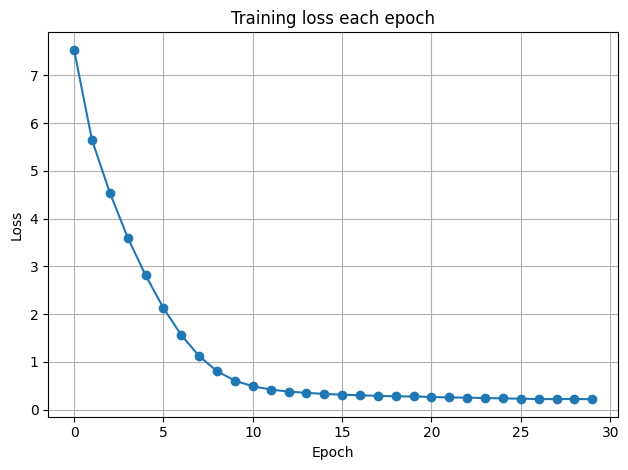


Generated text from TinyGPTDecoder:
.
: What kinds of things will Hijaak do that these shareware programs
: will not do?

I also use Graphic Workshop and the only differences that I know of are that
Hijaak has screen capture capabilities and acn convert to/ from a couple of
more file formats (don't know specifically which one).
 In the April 13
issue of PC Magazine they test the twelve best selling image capture/convert
utilities, including Hijaak.


In [1]:
import time
import cupy as cp
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer

# ----- Parameters  -----
NUM_PCA_COMPONENTS = 70  # up to 100
BLOCK_SIZE = 100

# ----- Data and tokenizer -----
newsgroups = fetch_20newsgroups(subset='train')
raw_texts = newsgroups.data[:100]
tokenizer = AutoTokenizer.from_pretrained("gpt2")
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# ----- Segmentation function -----
def split_into_blocks(text, block_size=BLOCK_SIZE):
    encoding = tokenizer(text, truncation=True, max_length=1024, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
    return [tokens[i:i+block_size] for i in range(0, len(tokens)-block_size+1, block_size)]

# ----- Find PCA basis from the first 100-token block -----
pca_base_block = None
for doc in raw_texts:
    blocks = split_into_blocks(doc)
    for token_block in blocks:
        if len(token_block) == BLOCK_SIZE:
            pca_base_block = token_block
            break
    if pca_base_block is not None:
        break

if pca_base_block is None:
    raise ValueError("No text with exact 100 tokens was found")
# Convert GPT2 tokens into individual strings
base_token_texts = [tokenizer.convert_tokens_to_string([t]) for t in pca_base_block]

# MiniLM-embedding
base_embeddings = embedder.encode(base_token_texts, convert_to_numpy=True)
base_mean = np.mean(base_embeddings, axis=0)
base_centered = base_embeddings - base_mean
base_gpu = cp.asarray(base_centered)
U, S, Vt = cp.linalg.svd(base_gpu, full_matrices=False)

# ----- Collect training blocks -----
input_tensors = []
target_tensors = []

for doc in raw_texts:
    blocks = split_into_blocks(doc)
    for token_block in blocks:
        if len(token_block) < BLOCK_SIZE:
            continue
        token_strs = [tokenizer.convert_tokens_to_string([t]) for t in token_block]
        emb = embedder.encode(token_strs, convert_to_numpy=True)
        emb_centered = emb - base_mean
        emb_gpu = cp.asarray(emb_centered)
        proj = emb_gpu @ Vt.T[:, :NUM_PCA_COMPONENTS]
        compressed = cp.asnumpy(proj)
        ids = tokenizer.convert_tokens_to_ids(token_block)
        input_tensors.append(torch.tensor(compressed, dtype=torch.float32))
        target_tensors.append(torch.tensor(ids[:BLOCK_SIZE], dtype=torch.long))

if len(input_tensors) == 0:
    raise RuntimeError("No training blocks generated")

input_tensor = torch.stack(input_tensors)
target_tensor = torch.stack(target_tensors)

# ----- Tiny Transformer Decoder -----
class TinyGPTDecoder(nn.Module):
    def __init__(self, input_dim=70, seq_len=100, vocab_size=50257):
        super().__init__()
        self.seq_len = seq_len
        d_model = input_dim
        self.pos_encoder = nn.Parameter(self._positional_encoding(seq_len, d_model), requires_grad=False)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=2, dim_feedforward=256, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=2)
        self.output_head = nn.Linear(d_model, vocab_size)

    def _positional_encoding(self, seq_len, d_model):
        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, memory):
        tgt = memory + self.pos_encoder[:, :memory.size(1), :]
        tgt_mask = torch.triu(torch.ones(self.seq_len, self.seq_len) * float('-inf'), diagonal=1).to(memory.device)
        out = self.decoder(tgt, memory, tgt_mask=tgt_mask)
        return self.output_head(out)

# ----- Training-----
model = TinyGPTDecoder(input_dim=NUM_PCA_COMPONENTS).train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
loss_history = []

for epoch in range(30):
    epoch_loss = 0
    for x, y in zip(input_tensor, target_tensor):
        x = x.unsqueeze(0)
        y = y.unsqueeze(0)
        output = model(x)
        loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(input_tensor)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

# ----- Loss plot -----
plt.plot(loss_history, marker='o')
plt.title("Training loss each epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# ----- Inference -----
model.eval()
with torch.no_grad():
    output = model(input_tensor[-1].unsqueeze(0))
    top_tokens = torch.argmax(output, dim=-1).squeeze().tolist()
    text = tokenizer.decode(top_tokens[:1024], skip_special_tokens=True)

print("\nGenerated text from TinyGPTDecoder:")
print(text)


CPU vs GPU ------------ PCA

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Original sentence:
Original tensor shape: (100, 384) (tokens × dimensions)
Artificial intelligence is transforming the world across industries. From autonomous vehicles to personalized medicine, AI systems are learning to interpret complex patterns and make decisions with minimal human input. By training models on massive datasets, researchers have unlocked capabilities once thought to be science fiction. Still, challenges remain, including explainability, bias, and energy usage. Continued innovation in efficient architectures, such as transformer models and knowledge distillation, will be key. Artificial intelligence is transforming the world across industries. From autonomous vehicles to personalized medicine, AI systems are learning to interpret complex patterns and make decisions with minimal human input. By training

Reconstructed:
world intelligence to learning the world in the in learning the to world the world world to learning to the world Continued and in world in world the i

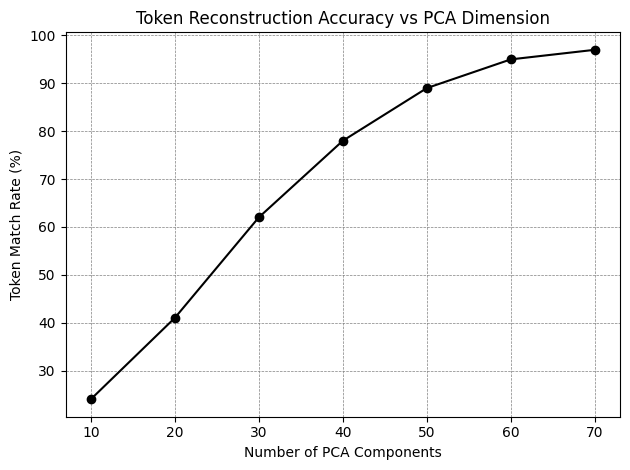

CPU PCA time: 1.440712 seconds
GPU PCA time: 0.008719 seconds
Mean cosine similarity (CPU reconstruction): 0.7620
Mean cosine similarity (GPU reconstruction): 0.7192

Reconstructed text from GPU:
Artificial intelligence is transformer the world in industries. From autonomous models to models world learning systems are learning to interpret complex patterns and make decisions with minimal the in By training models on the datasets, researchers have on capabilities once thought to be science world Still, challenges remain, and explainability, bias, and energy usage. Continued innovation in efficient architectures, such and transformer models and knowledge learning will be key. Artificial intelligence is transformer the world in industries. From autonomous models to models world learning systems are learning to interpret complex patterns and make decisions with minimal the in By training


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Causal mask for decoder
def generate_causal_mask(seq_len):
    mask = torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1)
    return mask

# PCA-GPT-like minimal decoder
class PcaGPTDecoder(nn.Module):
    def __init__(self, input_dim=30, seq_len=100, vocab_size=10000):
        super().__init__()
        self.seq_len = seq_len
        d_model = input_dim
        n_heads = 2 if d_model >= 4 else 1
        dim_feedforward = max(4 * d_model, 16)

        self.pos_encoder = PositionalEncoding(d_model=d_model, max_len=seq_len)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=2)
        self.output_head = nn.Linear(d_model, vocab_size)

    def forward(self, x_memory, tgt_input):
        causal_mask = generate_causal_mask(self.seq_len).to(tgt_input.device)
        x = self.pos_encoder(tgt_input)
        out = self.decoder(x, x_memory, tgt_mask=causal_mask)
        return self.output_head(out)

# Sinusoidal positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# PCA Tankeexperiment
if __name__ == "__main__":
    model_name = 'all-MiniLM-L6-v2'
    embedder = SentenceTransformer(model_name)
    base_sentence = (
        "In the realm of ideas everything depends on enthusiasm... in the real world all rests on perseverance. "
        "This quote repeats itself again and again until we reach precisely one hundred words to test how much can be reconstructed "
        "through PCA analysis when fed into a transformer embedding model like MiniLM. Let's see how well it holds up. "
        * 2
    )
    original_sentence = (
    "Artificial intelligence is transforming the world across industries. From autonomous vehicles to personalized medicine, "
    "AI systems are learning to interpret complex patterns and make decisions with minimal human input. By training models on massive datasets, "
    "researchers have unlocked capabilities once thought to be science fiction. Still, challenges remain, including explainability, bias, and energy usage. "
    "Continued innovation in efficient architectures, such as transformer models and knowledge distillation, will be key. "
    * 2
)

    base_tokens = base_sentence.strip().split()
    tokens = original_sentence.strip().split()
    base_segments = base_tokens[:100]
    segments = tokens[:100]
    embeddings = embedder.encode(segments)
    base_embeddings = embedder.encode(base_segments)

    print("Original sentence:")
    print(f"Original tensor shape: {embeddings.shape} (tokens × dimensions)")
    print(" ".join(segments))
    start_cpu = time.time()
    match_scores = []
    n_components_list = [10,20,30,40,50,60,70]

    for n_components in n_components_list:
        pca = PCA(n_components=n_components)
        Z_base = pca.fit_transform(base_embeddings)
        Z = pca.transform(embeddings)
        X_reconstructed = pca.inverse_transform(Z)

        # Cosine similarity per token
        similarities_cpu = cosine_similarity(embeddings, X_reconstructed)
        diagonal_sim = np.mean(np.diag(similarities_cpu))

        # Rekonstruera token-ord genom närmsta grann
        reconstructed_tokens = []
        for i in range(len(segments)):
            sims = cosine_similarity([X_reconstructed[i]], embeddings)[0]
            best_match_idx = np.argmax(sims)
            reconstructed_tokens.append(segments[best_match_idx])

        print("\nReconstructed:")
        print(" ".join(reconstructed_tokens))
        print("Original:")
        print(" ".join(segments))

        match_count = sum([segments[i] == reconstructed_tokens[i] for i in range(len(segments))])
        match_percentage = 100 * match_count / len(segments)
        match_scores.append(match_percentage)

        print(f"Match rate: {match_percentage:.2f}%")

    # Plotta träffprocent

    plt.plot(n_components_list, match_scores, marker='o', color='black')
    plt.xlabel('Number of PCA Components', color='black')
    plt.ylabel('Token Match Rate (%)', color='black')
    plt.title('Token Reconstruction Accuracy vs PCA Dimension', color='black')
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()



cpu_time = time.time() - start_cpu
# PCA-bas från base_embeddings
base_mean = np.mean(base_embeddings, axis=0)
base_centered = base_embeddings - base_mean
base_gpu = cp.asarray(base_centered)
mean_gpu = cp.asarray(base_mean)

start_gpu = time.time()
U, S, Vt = cp.linalg.svd(base_gpu, full_matrices=False)

# Nu: projicera nya embeddings mot referensbas
emb_centered = embeddings - base_mean
emb_gpu = cp.asarray(emb_centered)
Z_gpu = emb_gpu @ Vt.T[:, :40]
X_reconstructed_gpu = Z_gpu @ Vt[:40, :] + mean_gpu
cp.cuda.Device().synchronize()
gpu_time = time.time() - start_gpu
print(f"CPU PCA time: {cpu_time:.6f} seconds")
print(f"GPU PCA time: {gpu_time:.6f} seconds")


# Cosine likhet CPU
similarities_cpu = cosine_similarity(embeddings, X_reconstructed)
score_cpu = np.mean(np.diag(similarities_cpu))

# Cosine likhet GPU
similarities_gpu = cosine_similarity(embeddings, cp.asnumpy(X_reconstructed_gpu))

score_gpu = np.mean(np.diag(similarities_gpu))

print(f"Mean cosine similarity (CPU reconstruction): {score_cpu:.4f}")
print(f"Mean cosine similarity (GPU reconstruction): {score_gpu:.4f}")


# ----- Tokenrekonstruktion från GPU -----
X_rec_np = cp.asnumpy(X_reconstructed_gpu)
reconstructed_tokens_gpu = []
for i in range(len(X_rec_np)):
    sims = cosine_similarity([X_rec_np[i]], embeddings)[0]
    best_match_idx = np.argmax(sims)
    reconstructed_tokens_gpu.append(tokens[best_match_idx])

print("\nReconstructed text from GPU:")
print(" ".join(reconstructed_tokens_gpu))
